In [1]:
import pandas as pd
import math
import numpy as np
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

/Users/sydneydecoto/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load and clean the data

In [2]:
df=pd.read_csv('data/churn.csv')
df.head()

df = df.replace("yes", True)
df = df.replace("no", False)
df = df.replace("True.", True)
df = df.replace("False.", False)
df = df.drop(['State', 'Area Code', 'Phone'], axis=1)
y = df['Churn?'].values
X = df.drop('Churn?', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

/Users/sydneydecoto/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


### Create a cost benefit matrix

In [3]:
#Cost assumptions
'''Cost of FP: 1, cost of FN: 2, cost of TN: 0, cost of TP: -1'''
cost_TP = -1; cost_FP = 1; cost_FN = 2; cost_TN = 0;
cb_matrix = -1*np.array([[cost_TP, cost_FP],[cost_FN, cost_TN]])

In [4]:
#Convert to standard confusion matrix
def standard_confusion_matrix(y_true, y_predict):
    TP = sum((y_true == 1) & (y_predict == 1))
    TN = sum((y_true == 0) & (y_predict == 0))
    FP = sum((y_true == 0) & (y_predict == 1))
    FN = sum((y_true == 1) & (y_predict == 0))
    
    return np.array([[TP,FP],[FN,TN]])

### Calculate profit curve

In [5]:
def profit_curve(cb, predict_probas, labels):
    #predict_probas = round(predict_probas,4)
    indices = np.argsort(predict_probas)
    sorted_probs = predict_probas[indices]
    sorted_labels = labels[indices]
    
    profit_list = []
    
    for sp, sl in zip(sorted_probs, sorted_labels):
        predict_labels = sorted_probs > sp + .0001
        conf_mat = standard_confusion_matrix(sorted_labels, predict_labels)
        profit_list.append((cb * conf_mat).sum() / float(len(labels)))
    return profit_list, sorted_probs

### Plot profit curve

In [6]:
# Plot the profit curves
def plot_profit_curve(model, label, costbenefit, X_train, X_test, y_train, y_test, col):
    model.fit(X_train, y_train)
    predict_probas = model.predict_proba(X_test)[:,1]
    profit_list, sorted_probs = profit_curve(costbenefit, predict_probas, y_test)
    max_index = np.argmax(profit_list)
    max_threshold = sorted_probs[max_index]
    max_profit = profit_list[max_index]
    
    plt.plot(sorted_probs, profit_list, label=label, color=col, linewidth=3)
    plt.plot(max_threshold, max_profit, '.', color=col, markersize=18)

### Plot the profit curves and mark the optimum point for each model

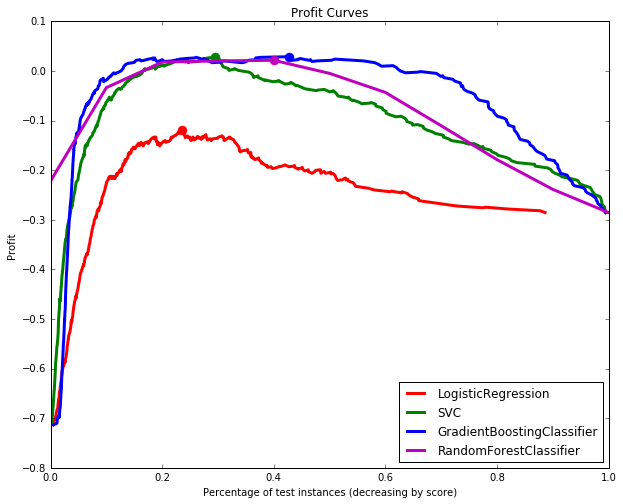

In [7]:
models = [LR(), SVC(probability=True), GBC(), RF()]
fig = plt.figure(figsize=(10,8))
# fig.set_facecolor('#F2F2F2')
colors = ['r', 'g', 'b', 'm']
for i, model in enumerate(models):
    plot_profit_curve(model, model.__class__.__name__, cb_matrix,
                      X_train, X_test, y_train, y_test, colors[i])
plt.title("Profit Curves")
plt.xlabel("Percentage of test instances (decreasing by score)")
plt.ylabel("Profit")
plt.legend(loc='lower right')
plt.savefig('Profit_curve.png', facecolor=fig.get_facecolor())
plt.show()

### Just for fun, plot in the style of the xkcd cartoon

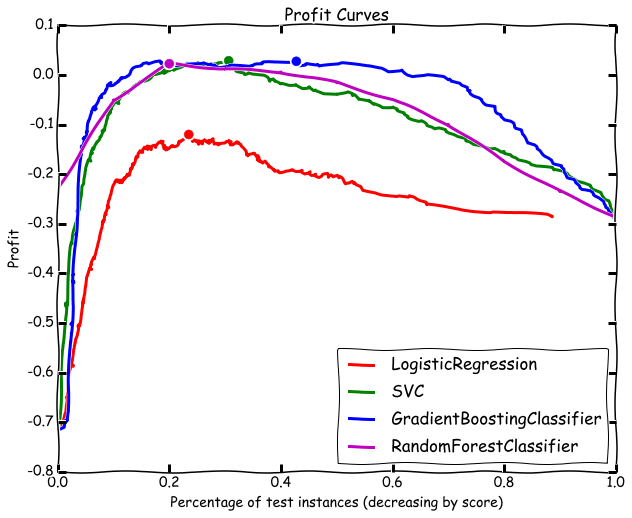

In [8]:
models = [LR(), SVC(probability=True), GBC(), RF()]
fig = plt.figure(figsize=(10,8))
plt.xkcd()
# fig.set_facecolor('#F2F2F2')
colors = ['r', 'g', 'b', 'm']
for i, model in enumerate(models):
    plot_profit_curve(model, model.__class__.__name__, cb_matrix,
                      X_train, X_test, y_train, y_test, colors[i])
plt.title("Profit Curves")
plt.xlabel("Percentage of test instances (decreasing by score)")
plt.ylabel("Profit")
plt.legend(loc='lower right')
plt.savefig('Profit_curve_xkcda.png', facecolor=fig.get_facecolor())
plt.show()